In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import generate, load
from mlx_lm.tuner import TrainingArgs, linear_to_lora_layers, train

from mlx_utils import load_hf_dataset

In [2]:
model_path = "mlx-community/Mistral-7B-Instruct-v0.3-4bit"
model, tokenizer = load(model_path)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
prompt = "What is under-fitting and overfitting in machine learning?"
messages = [{"role": "user", "content": prompt}]
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [4]:
response = generate(model, tokenizer, prompt=prompt, verbose=True)

Under-fitting and overfitting are two common problems that can occur when training machine learning models.

1. Under-fitting: This occurs when a model is too simple to learn the underlying pattern in the data. In other words, the model is not complex enough to capture the relationship between the input and output variables. As a result, the model's performance on both the training and test data is poor. This can happen when the model has too few parameters, or when the model is not trained for long enough.

2. Overfitting: This occurs when a model is too complex and starts to fit the noise in the data instead of the underlying pattern. In other words, the model is learning the idiosyncrasies of the training data rather than the general pattern that applies to new, unseen data. As a result, the model performs well on the training data but poorly on the test data. This can happen when the model has too many parameters, or when the model is trained for too long.

The goal in machine lear

# Model fine-tuning

In [5]:
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

Set the LoRA parameters.

In [6]:
lora_config = {
 "num_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

In [7]:
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)

Set the training parameters.

In [8]:
training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=200,
    steps_per_eval=50
)

Freeze the base model

In [9]:
_ = model.freeze()

Convert the linear layers to LoRA layers

In [10]:
linear_to_lora_layers(model, lora_config["num_layers"], lora_config["lora_parameters"])

Check the trainable model parameters.

In [11]:
num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 3407872


Training mode

In [12]:
_ = model.train()

In [13]:
opt = optim.Adam(learning_rate=1e-5)

Class to record the data during the training process.

In [14]:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))

In [15]:
metrics = Metrics()

Start fine-tuning

In [16]:
train_set, valid_set, test_set = load_hf_dataset("win-wang/Machine_Learning_QA_Collection", tokenizer)

In [17]:
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=valid_set,
    training_callback=metrics,
)

Starting training..., iters: 200
Iter 1: Val loss 2.400, Val took 91.158s
Iter 10: Train loss 1.987, Learning Rate 1.000e-05, It/sec 0.128, Tokens/sec 110.636, Trained Tokens 8625, Peak mem 20.312 GB
Iter 20: Train loss 1.935, Learning Rate 1.000e-05, It/sec 0.102, Tokens/sec 121.555, Trained Tokens 20529, Peak mem 20.312 GB
Iter 30: Train loss 1.748, Learning Rate 1.000e-05, It/sec 0.114, Tokens/sec 109.036, Trained Tokens 30121, Peak mem 20.312 GB
Iter 40: Train loss 1.682, Learning Rate 1.000e-05, It/sec 0.128, Tokens/sec 117.938, Trained Tokens 39307, Peak mem 21.941 GB
Iter 50: Val loss 1.813, Val took 66.287s
Iter 50: Train loss 1.807, Learning Rate 1.000e-05, It/sec 3.317, Tokens/sec 2554.015, Trained Tokens 47007, Peak mem 21.941 GB
Iter 60: Train loss 1.767, Learning Rate 1.000e-05, It/sec 0.122, Tokens/sec 121.253, Trained Tokens 56912, Peak mem 21.941 GB
Iter 70: Train loss 1.645, Learning Rate 1.000e-05, It/sec 0.141, Tokens/sec 120.172, Trained Tokens 65418, Peak mem 22.21

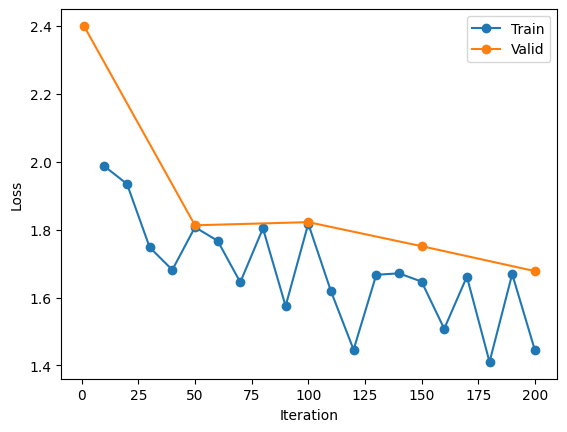

In [18]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

Test model_lora

In [19]:
model_lora, _ = load(model_path, adapter_path="adapters")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
model_lora, _ = load(model_path, adapter_path="adapters")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
generate(model_lora, tokenizer, prompt=prompt, verbose=True)

Under-fitting and overfitting are two common issues in machine learning models.

Under-fitting occurs when a model is too simple and fails to capture the underlying patterns in the data, leading to poor performance on the training and test data. This can be addressed by increasing the complexity of the model or adding more features.

Overfitting, on the other hand, occurs when a model is too complex and fits the training data too closely, resulting in poor generalization to new data. This can be addressed by simplifying the model, reducing the number of features, or using regularization techniques to prevent overfitting.
Prompt: 19 tokens, 157.288 tokens-per-sec
Generation: 131 tokens, 27.909 tokens-per-sec
Peak memory: 67.760 GB


'Under-fitting and overfitting are two common issues in machine learning models.\n\nUnder-fitting occurs when a model is too simple and fails to capture the underlying patterns in the data, leading to poor performance on the training and test data. This can be addressed by increasing the complexity of the model or adding more features.\n\nOverfitting, on the other hand, occurs when a model is too complex and fits the training data too closely, resulting in poor generalization to new data. This can be addressed by simplifying the model, reducing the number of features, or using regularization techniques to prevent overfitting.'